In [1]:
library(dplyr)
library(tidyverse)
library(ggplot2)
library(janitor)
library(scales)
 #library(openxlsx)
library(plotROC)

library(randomForest)
library(Matrix)
library(vip)
library(mlbench)
library(xgboost)
library(ParBayesianOptimization)
library(recipes)
library(caret)

library(pdp)

#parallelization
library(doRNG)
library(parallel)
library(doParallel)

library(missRanger)




Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.4
✔ ggplot2   3.4.4     ✔ stringr   1.5.0
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test



Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor


randomFore

In [17]:
# obtaining the merged economic dataset

library(reticulate)
sagemaker <- import('sagemaker')
role_arn <- sagemaker$get_execution_role()
session <- sagemaker$Session()
bucket <- "ecb-hackathon-data-group03-x19s00"
library(readr)


data_file <- 's3://ecb-hackathon-data-group03-x19s00/intermediate_data/economic_data.csv'
econ <- read_csv(file = sagemaker$s3$S3Downloader$read_file(data_file, sagemaker_session=session),
                    col_names = TRUE, show_col_types = FALSE)
#head(econ)

New names:
• `` -> `...1`


In [18]:
# obtaining the environmental data

data_file <- 's3://ecb-hackathon-data-group03-x19s00/intermediate_data/climate_merge_full.csv'
envir <- read_csv(file = sagemaker$s3$S3Downloader$read_file(data_file, sagemaker_session=session),
                    col_names = TRUE, show_col_types = FALSE)
#summary(envir)

New names:
• `` -> `...1`


In [25]:
# merging the two data sources
dat_full = envir |> left_join(econ, by = c("NUTS_ID" = "nuts3", "year" = "year"))

In [29]:
# I select the most important variables. In an ideal setting, this selection should be done by the machine learning method
# in our case, we do not have sufficient time to test everything

dat2 = dat_full |> arrange(NUTS_ID, year, nace) |> group_by(NUTS_ID, nace) |> mutate(gdp_lag = lag(gdp, 1)) |>
        select(absorbed_photosynthetically_active_radiation_anomaly_median_median,
               low_flow_index_monthly_max_max,
               soil_mosture_anomaly_median_median,
               precipitation_index_median_01_median,
               #precipitation_index_median_01_count,
               precipitation_index_median_06_median,
                precipitation_index_median_12_median,
               #precipitation_index_median_06_count,
               temp_max_median_median,
               heat_intensity_median_median,
               gdp, gdp_lag,
               employment_000s,
               value_added_mln_eur,
               nace,
               population,
              year)

Adding missing grouping variables: `NUTS_ID`


In [30]:
# there are many missing values in the data
# option 1: remove them; option 2: impute them. We go for the second, using a tree-based method

dat_imputed <- missRanger(dat2, pmm.k = 5, # predictive mean matching (if commented ==> off)
                          num.trees = 6,         # adjust for faster computation
                          sample.fraction = 0.2, # adjust for faster computation
                          max.depth = 10,          # adjust for faster computation
                          seed = 423432)



Missing value imputation by random forests

  Variables to impute:		absorbed_photosynthetically_active_radiation_anomaly_median_median, low_flow_index_monthly_max_max, soil_mosture_anomaly_median_median, precipitation_index_median_01_median, precipitation_index_median_06_median, precipitation_index_median_12_median, temp_max_median_median, heat_intensity_median_median, gdp, gdp_lag, employment_000s, value_added_mln_eur, nace, population
  Variables used to impute:	NUTS_ID, absorbed_photosynthetically_active_radiation_anomaly_median_median, low_flow_index_monthly_max_max, soil_mosture_anomaly_median_median, precipitation_index_median_01_median, precipitation_index_median_06_median, precipitation_index_median_12_median, temp_max_median_median, heat_intensity_median_median, gdp, gdp_lag, employment_000s, value_added_mln_eur, nace, population, year

iter 1
  |======================================================================| 100%
iter 2
  |============================================

In [32]:
# separating pre-2019 data
dat_imputed_train = dat_imputed |> filter(year < 2019) |> select(-year)

dat_imputed_validation = dat_imputed |> filter(year >= 2019) |> select(-year)

In [33]:
# feature engineering part

dat_imp2 = dat_imputed_train |> ungroup() |> mutate(va_pop = value_added_mln_eur/population,
                                                     empl_pop = employment_000s / population,
                                                     gdp_ch = gdp /gdp_lag,
                                                     gdp_pop = gdp / population) |> filter(population != 0) |>
            select(-value_added_mln_eur, -population, -employment_000s, -gdp, -gdp_lag) |>
            filter(!is.na(gdp_ch) & !is.na(empl_pop))

dat_imp2 = dat_imp2 |> mutate(nace = case_when(is.na(nace) ~ NA,
                                               nace == 'Agriculture, forestry and fishing [A]' ~ 'A',
                                               nace == 'Arts, entertainment and recreation; other service activities; activities of household and extra-territorial organizations and bodies [R-U]' ~ 'RU',
                                               nace == 'Construction [F]' ~ 'F',
                                               nace == 'Financial and insurance activities [K]' ~ 'K',
                                               nace == 'Financial and insurance activities; real estate activities; professional, scientific and technical activities; administrative and support service activities [K-N]' ~ 'KN',
                                               nace == 'Industry (except construction) [B-E]' ~ 'BE',
                                               nace == 'Information and communication [J]' ~ 'J',
                                               nace == 'Manufacturing [C]' ~ 'C',
                                               nace == 'Professional, scientific and technical activities; administrative and support service activities [M_N]' ~ 'MN',
                                               nace == 'Public administration and defence; compulsory social security; education; human health and social work activities; arts, entertainment and recreation, repair of household goods and other services [O-U]' ~ 'OU',
                                               nace == 'Public administration, defence, education, human health and social work activities [O-Q]' ~ 'OQ',
                                               nace == 'Real estate activities [L]' ~ 'L',
                                               nace == 'Total - all NACE activities [TOTAL]' ~ 'TOT',
                                               nace == 'Wholesale and retail trade, transport, accommodation and food service activities [G-I]' ~ 'GI',
                                               nace == 'Wholesale and retail trade; transport; accommodation and food service activities; information and communication [G-J]' ~ 'GJ',
                                               TRUE ~ nace))

dat_imp2$country = substr(dat_imp2$NUTS_ID,1,2)
dat_imp2$nace = as.factor(dat_imp2$nace)
dat_imp2$country = as.factor(dat_imp2$country)

dat_imp3 = dat_imp2 |> select(-NUTS_ID) #|> filter(nace %in% c('A','C'))

In [67]:
# splitting the data into train and test set
# the aws is very slow for R, I have to restrict model training to a small subset

# we explain value added / population

# train set
set.seed(3232)
train_split = sample(1:nrow(dat_imp3), round(nrow(dat_imp3) *.75,0), replace = F)
train_df = dat_imp3#[train_split,]


X = sparse.model.matrix(va_pop~., data = dat_imp3)[,-1]
y <- as.numeric(as.character(dat_imp3 |> pull((va_pop))))



# test dataset
test = dat_imp3[-train_split,]
X_test = sparse.model.matrix(va_pop~., data = test)[,-1]

y_test <- test |> pull((va_pop))




In [9]:
summary(y)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -2.276   1.020   2.738   4.849   5.828 166.002 

In [68]:
# fitting two xgboost models. The first is unconstrained, while the second enforces monotonic constraints.
# the variables where we put constraints were selected based on the feature importance (shown later), so in an iterative manner.
# we care about monotonic constraints only for the most important variables
# (hyperparamter tuning was removed, it is very slow on this R kernel)


opt_params <- list(eta = .8,
               max.depth = 20,
               min_child_weight = 30,
               subsample = 1,
               colsample_bytree = .9,
               gamma = 1)


# Get optimal number of rounds
nrounds = 100


##### ....fit an xgb model #####
mdl <- xgboost(data = X, label = y, 
               params = opt_params, 
               maximize = F, 
               early_stopping_rounds = 5, 
               nrounds = nrounds, 
               verbose = 0)


#colnames(X)
monotonic_constraints =    c(0, -1, -1, 0, 0, 0, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

##### ....fit an xgb model #####
mdl2 <- xgboost(data = X, label = y, 
               params = opt_params, 
               maximize = F, 
               monotone_constraints = monotonic_constraints,
               early_stopping_rounds = 5, 
               nrounds = nrounds, 
               verbose = 0)


In [74]:
colnames(X)

[1] "absorbed_photosynthetically_active_radiation_anomaly_median_median"
 [2] "low_flow_index_monthly_max_max"                                    
 [3] "soil_mosture_anomaly_median_median"                                
 [4] "precipitation_index_median_01_median"                              
 [5] "precipitation_index_median_06_median"                              
 [6] "precipitation_index_median_12_median"                              
 [7] "temp_max_median_median"                                            
 [8] "heat_intensity_median_median"                                      
 [9] "naceBE"                                                            
[10] "naceC"                                                             
[11] "naceF"                                                             
[12] "naceGI"                                                            
[13] "naceGJ"                                                            
[14] "naceJ"                                                             
[15] "naceK"                                                             
[16] "naceKN"                                                            
[17] "naceL"                                                             
[18] "naceMN"                                                            
[19] "naceOQ"                                                            
[20] "naceOU"                                                            
[21] "naceRU"                                                            
[22] "naceTOT"                                                           
[23] "empl_pop"                                                          
[24] "gdp_ch"                                                            
[25] "gdp_pop"                                                           
[26] "countryAL"                                                         
[27] "countryAT"                                                         
[28] "countryBA"                                                         
[29] "countryBE"                                                         
[30] "countryBG"                                                         
[31] "countryCH"                                                         
[32] "countryCY"                                                         
[33] "countryCZ"                                                         
[34] "countryDE"                                                         
[35] "countryDK"                                                         
[36] "countryEE"                                                         
[37] "countryEL"                                                         
[38] "countryES"                                                         
[39] "countryFI"                                                         
[40] "countryFR"                                                         
[41] "countryHR"                                                         
[42] "countryHU"                                                         
[43] "countryIE"                                                         
[44] "countryIS"                                                         
[45] "countryIT"                                                         
[46] "countryLI"                                                         
[47] "countryLT"                                                         
[48] "countryLU"                                                         
[49] "countryLV"                                                         
[50] "countryME"                                                         
[51] "countryMK"                                                         
[52] "countryMT"                                                         
[53] "countryNL"                                                         
[54] "countryNO"                                                         
[55] 

In [71]:
# feature importance
xgb.importance(colnames(X), model = mdl)[1:10,]

Feature                        Gain        Cover       Frequency  
1  empl_pop                       0.694455371 0.366266958 0.195743730
2  gdp_pop                        0.236850387 0.199887827 0.110426903
3  naceTOT                        0.015228163 0.003793232 0.003828728
4  gdp_ch                         0.005445520 0.063669980 0.082126220
5  naceKN                         0.004794088 0.004052232 0.002712016
6  temp_max_median_median         0.004491638 0.047892094 0.077818901
7  low_flow_index_monthly_max_max 0.004063538 0.030302997 0.081743348
8  heat_intensity_median_median   0.003815851 0.034255641 0.077467934
9  naceBE                         0.003808997 0.005599400 0.004339225
10 naceC                          0.003254235 0.004988706 0.003382043

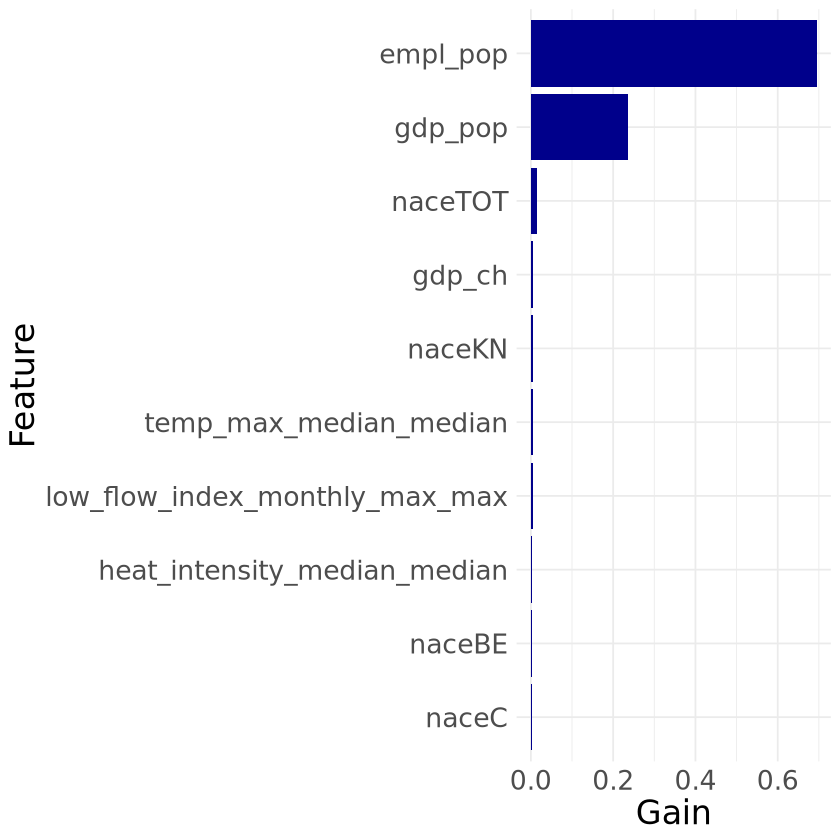

In [176]:
imp = xgb.importance(colnames(X), model = mdl)[1:10,]
imp$Feature = fct_reorder(imp$Feature, imp$Gain, .desc = F)
plot = ggplot() + geom_bar(data = imp, aes(Feature, Gain), stat = "identity", fill = "darkblue") + coord_flip()+theme_minimal()+
theme(text = element_text(size=20))
plot
ggsave(plot, width = 6, height = 6,  filename = "feature_importance.pdf")

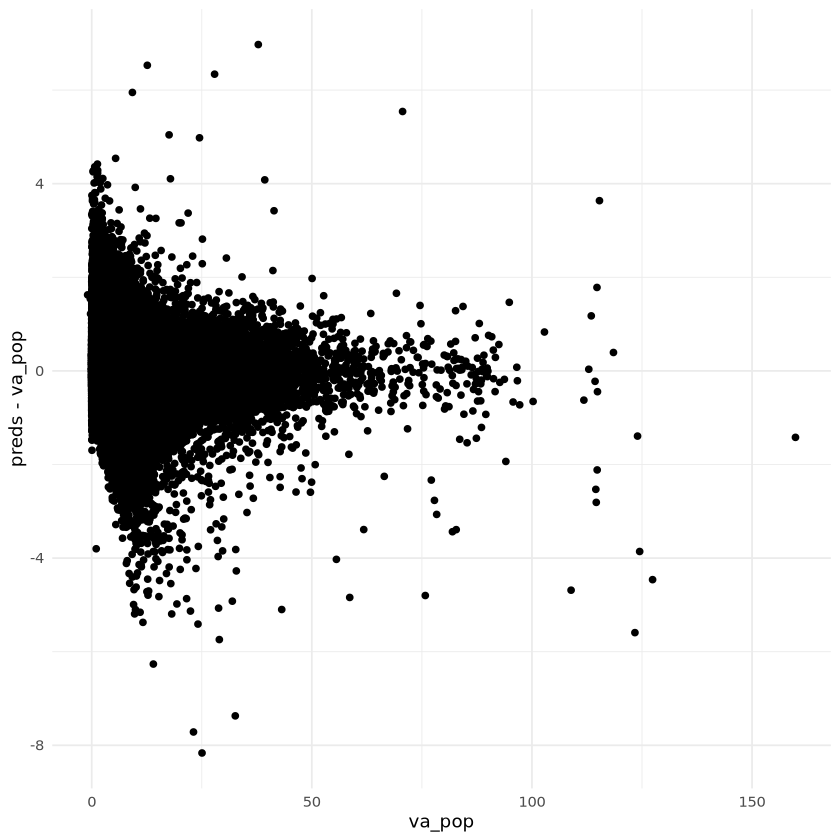

In [124]:
# residual plot using the test data

test$preds = predict(mdl, X_test)

ggplot() + geom_point(data = test, aes(va_pop, preds - va_pop)) + theme_minimal()

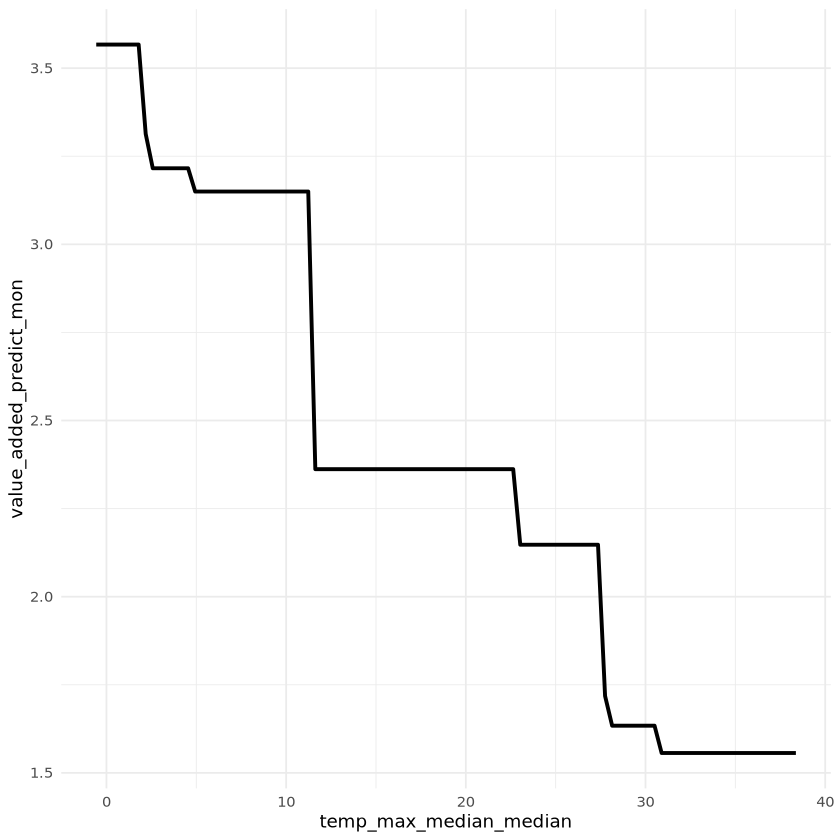

In [75]:
# I do the partial dependency plots by hand, the library I normally use does not come through aws

pdp = head(dat_imp3, 100)


pdp$absorbed_photosynthetically_active_radiation_anomaly_median_median = median(dat_imp3$absorbed_photosynthetically_active_radiation_anomaly_median_median)
pdp$low_flow_index_monthly_max_max = median(dat_imp3$low_flow_index_monthly_max_max)
pdp$soil_mosture_anomaly_median_median = median(dat_imp3$soil_mosture_anomaly_median_median)
pdp$precipitation_index_median_01_median = median(dat_imp3$precipitation_index_median_01_median)
pdp$precipitation_index_median_06_median = median(dat_imp3$precipitation_index_median_06_median)
pdp$precipitation_index_median_12_median = median(dat_imp3$precipitation_index_median_12_median)
pdp$temp_max_median_median = median(dat_imp3$temp_max_median_median)
pdp$heat_intensity_median_median = median(dat_imp3$heat_intensity_median_median)
pdp$gdp_pop = median(dat_imp3$gdp_pop)
pdp$temp_max_median_median = seq(from = min(dat_imp3$temp_max_median_median),
                                       to = max(dat_imp3$temp_max_median_median),
                                       by = (max(dat_imp3$temp_max_median_median) - min(dat_imp3$temp_max_median_median))/99)

pdp$nace = NULL
#pdp$naceA = 1
pdp$naceC = 0
pdp$naceA = 0
pdp$naceBE = 0
pdp$naceC = 0
pdp$naceF = 0
pdp$naceGI = 0
pdp$naceGJ = 0
pdp$naceJ = 0
pdp$naceK = 0
pdp$naceKN = 0
pdp$naceL = 0
pdp$naceMN = 0
pdp$naceOQ = 0
pdp$naceOU  = 0
pdp$naceRU = 0
pdp$naceTOT = 0

pdp$empl_pop = median(dat_imp3$empl_pop)
pdp$gdp_ch = median(dat_imp3$gdp_ch)


pdp$country = NULL
pdp$countryIE = 0
pdp$countryAT = 0
pdp$countryNL = 0
pdp$countryDE = 0
pdp$countryNO = 0
pdp$countryDK = 0
pdp$countryBE = 0
pdp$countryUK = 0
pdp$countryFR = 0
pdp$countryEL = 1
pdp$countrySE = 0
pdp$countryES = 0
pdp$countryPT = 0
pdp$countryTR = 0
pdp$countryHU = 0
pdp$countrySI = 0
pdp$countryFI = 0
pdp$countryRO = 0
pdp$countryMT = 0
pdp$countryCH = 0
pdp$countryAL = 0
pdp$countryPL = 0
pdp$countryBG = 0
pdp$countryRS = 0
pdp$countrySK = 0
pdp$countryBA = 0
pdp$countryIT = 0
pdp$countryCZ = 0
pdp$countryLT = 0
pdp$countryLU = 0
pdp$countryUK = 0
pdp$countryCY = 0
pdp$countryEE = 0
pdp$countryHR = 0
pdp$countryMK = 0
pdp$countryAD = 0
pdp$countryIS = 0
pdp$countryLI = 0
pdp$countryLV = 0
pdp$countryME = 0

X_pdp = sparse.model.matrix(va_pop~., data = pdp)[,-1]
X_pdp = X_pdp[,match(colnames(X),colnames(X_pdp))]


pdp$value_added_predict = predict(mdl, X_pdp)
pdp$value_added_predict_mon = predict(mdl2, X_pdp)

p= 
ggplot() + #geom_line(data = pdp, aes(temp_max_median_median, value_added_predict, group = "unconstrained", color = "unconstrained"), linewidth = 1.1) +
           geom_line(data = pdp, aes(temp_max_median_median, value_added_predict_mon, group = 1), linewidth = 1.1) +
           theme_minimal()+scale_color_viridis_d()
p
#ggsave(p, width = 8, height = 6,  filename = "temperature_sector_pdp.pdf")

In [162]:
pdp = head(dat_imp3, 100)


pdp$absorbed_photosynthetically_active_radiation_anomaly_median_median = median(dat_imp3$absorbed_photosynthetically_active_radiation_anomaly_median_median)
pdp$low_flow_index_monthly_max_max = median(dat_imp3$low_flow_index_monthly_max_max)
pdp$soil_mosture_anomaly_median_median = median(dat_imp3$soil_mosture_anomaly_median_median)
pdp$precipitation_index_median_01_median = median(dat_imp3$precipitation_index_median_01_median)
pdp$precipitation_index_median_06_median = median(dat_imp3$precipitation_index_median_06_median)
pdp$precipitation_index_median_12_median = median(dat_imp3$precipitation_index_median_12_median)
pdp$temp_max_median_median = median(dat_imp3$temp_max_median_median)
pdp$heat_intensity_median_median = median(dat_imp3$heat_intensity_median_median)
pdp$gdp_pop = median(dat_imp3$gdp_pop)
pdp$temp_max_median_median = seq(from = min(dat_imp3$temp_max_median_median),
                                       to = max(dat_imp3$temp_max_median_median),
                                       by = (max(dat_imp3$temp_max_median_median) - min(dat_imp3$temp_max_median_median))/99)


pdp$empl_pop = median(dat_imp3$empl_pop)
pdp$gdp_ch = median(dat_imp3$gdp_ch)
        
pdp$nace = NULL
#pdp$naceA = 1
pdp$naceC = 1
pdp$naceA = 0
pdp$naceBE = 0
pdp$naceF = 0
pdp$naceGI = 0
pdp$naceGJ = 0
pdp$naceJ = 0
pdp$naceK = 0
pdp$naceKN = 0
pdp$naceL = 0
pdp$naceMN = 0
pdp$naceOQ = 0
pdp$naceOU  = 0
pdp$naceRU = 0
pdp$naceTOT = 0

pdp$empl_pop = median(dat_imp3$empl_pop)
pdp$gdp_ch = median(dat_imp3$gdp_ch)


pdp$country = NULL
pdp$countryIE = 0
pdp$countryAT = 0
pdp$countryNL = 0
pdp$countryDE = 0
pdp$countryNO = 0
pdp$countryDK = 0
pdp$countryBE = 0
pdp$countryUK = 0
pdp$countryFR = 0
pdp$countryEL = 1
pdp$countrySE = 0
pdp$countryES = 0
pdp$countryPT = 0
pdp$countryTR = 0
pdp$countryHU = 0
pdp$countrySI = 0
pdp$countryFI = 0
pdp$countryRO = 0
pdp$countryMT = 0
pdp$countryCH = 0
pdp$countryAL = 0
pdp$countryPL = 0
pdp$countryBG = 0
pdp$countryRS = 0
pdp$countrySK = 0
pdp$countryBA = 0
pdp$countryIT = 0
pdp$countryCZ = 0
pdp$countryLT = 0
pdp$countryLU = 0
pdp$countryUK = 0
pdp$countryCY = 0
pdp$countryEE = 0
pdp$countryHR = 0
pdp$countryMK = 0
pdp$countryAD = 0
pdp$countryIS = 0
pdp$countryLI = 0
pdp$countryLV = 0
pdp$countryME = 0
 #attributes(pdp$nace) =   attributes(dat_imp3$nace)           

pdp2 = pdp
pdp2$naceC = 0

#attributes(pdp2$nace) =   attributes(dat_imp3$nace) 
pdp3 = rbind(pdp, pdp2)

X_pdp = sparse.model.matrix(va_pop~., data = pdp3)[,-1]

X_pdp = X_pdp[,match(colnames(X),as.character(colnames(X_pdp)))]

pdp3$va_pop_pred = predict(mdl, X_pdp)
pdp3$va_pop_pred_mon = predict(mdl2, X_pdp)

pdp3$sector = ifelse(pdp3$naceC == 1, 'Manufacturing (C)','Agriculture (A)')


p2=
ggplot() + geom_line(data = pdp3, aes(temp_max_median_median, va_pop_pred_mon, group = sector, color = sector), size = 1.1) +
theme_minimal() +
 scale_color_viridis_d(option = "turbo")+ylab("Value added by population")+ theme(legend.position = c(.7,.85))



#ggsave(p2, width = 12, height = 6,  filename = "temp_sector_pdp_2.pdf")

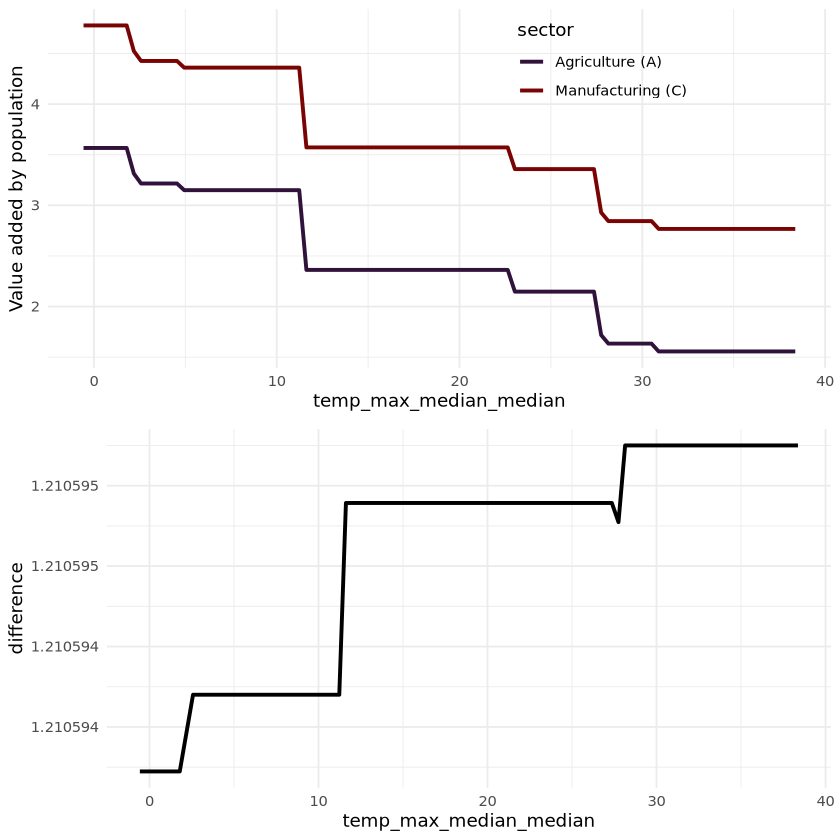

In [163]:
difference_bw_sectors = pdp3 |> ungroup() |> select(temp_max_median_median, sector, va_pop_pred_mon) |> pivot_wider(id_cols = temp_max_median_median, names_from = sector, values_from = va_pop_pred_mon) |> rename(Sector_C = 2, Sector_A = 3) |> mutate(difference = Sector_C-Sector_A)

p3 = ggplot() + geom_line(data = difference_bw_sectors, aes(temp_max_median_median, difference, group = 1), linewidth = 1.1)+theme_minimal()
p_empty = ggplot() + theme_void()
plot_to_save = ggarrange(p2, p3, ncol = 1, nrow = 2)
plot_to_save
ggsave(plot_to_save, width = 12, height = 12,  filename = "temp_sector_pdp_2_with_difference.pdf")


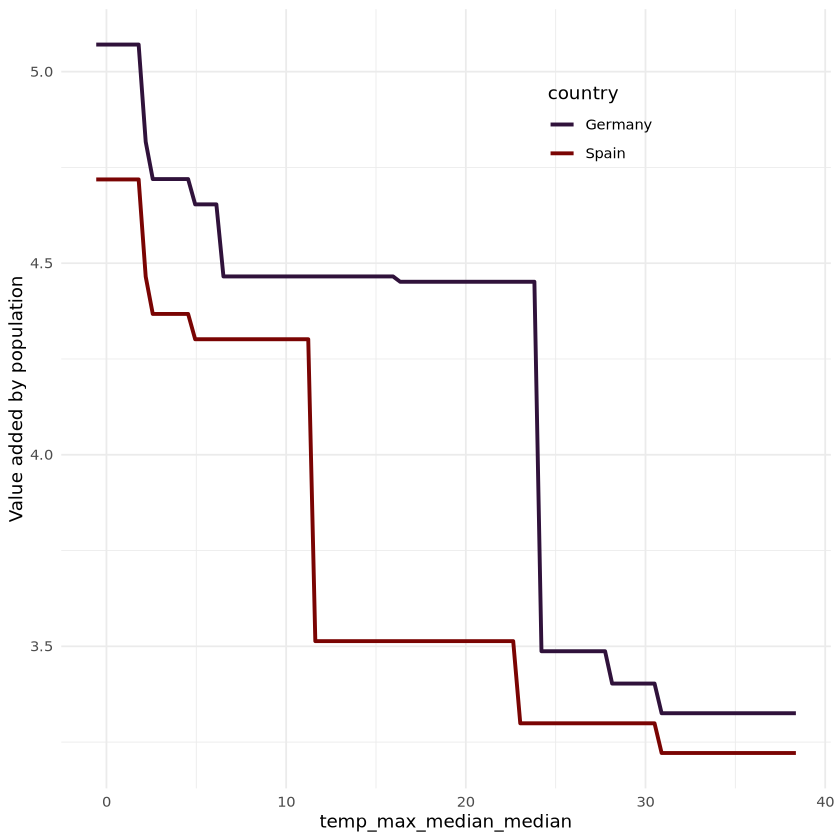

In [164]:
pdp = head(dat_imp3, 100)


pdp$absorbed_photosynthetically_active_radiation_anomaly_median_median = median(dat_imp3$absorbed_photosynthetically_active_radiation_anomaly_median_median)
pdp$low_flow_index_monthly_max_max = median(dat_imp3$low_flow_index_monthly_max_max)
pdp$soil_mosture_anomaly_median_median = median(dat_imp3$soil_mosture_anomaly_median_median)
pdp$precipitation_index_median_01_median = median(dat_imp3$precipitation_index_median_01_median)
pdp$precipitation_index_median_06_median = median(dat_imp3$precipitation_index_median_06_median)
pdp$precipitation_index_median_12_median = median(dat_imp3$precipitation_index_median_12_median)
pdp$temp_max_median_median = median(dat_imp3$temp_max_median_median)
pdp$heat_intensity_median_median = median(dat_imp3$heat_intensity_median_median)
pdp$gdp_pop = as.numeric(dat_imp3 |> filter(country == 'DE') |> select(gdp_pop) |> summarize(median(gdp_pop)))
pdp$temp_max_median_median = seq(from = min(dat_imp3$temp_max_median_median),
                                       to = max(dat_imp3$temp_max_median_median),
                                       by = (max(dat_imp3$temp_max_median_median) - min(dat_imp3$temp_max_median_median))/99)


pdp$empl_pop = median(dat_imp3$empl_pop)
pdp$gdp_ch = median(dat_imp3$gdp_ch)
        
pdp$nace = NULL
#pdp$naceA = 1
pdp$naceC = 1
pdp$naceA = 0
pdp$naceBE = 0
pdp$naceF = 0
pdp$naceGI = 0
pdp$naceGJ = 0
pdp$naceJ = 0
pdp$naceK = 0
pdp$naceKN = 0
pdp$naceL = 0
pdp$naceMN = 0
pdp$naceOQ = 0
pdp$naceOU  = 0
pdp$naceRU = 0
pdp$naceTOT = 0

pdp$empl_pop = median(dat_imp3$empl_pop)
pdp$gdp_ch = median(dat_imp3$gdp_ch)


pdp$country = NULL
pdp$countryIE = 0
pdp$countryAT = 0
pdp$countryNL = 0
pdp$countryDE = 1
pdp$countryNO = 0
pdp$countryDK = 0
pdp$countryBE = 0
pdp$countryUK = 0
pdp$countryFR = 0
pdp$countryEL = 0
pdp$countrySE = 0
pdp$countryES = 0
pdp$countryPT = 0
pdp$countryTR = 0
pdp$countryHU = 0
pdp$countrySI = 0
pdp$countryFI = 0
pdp$countryRO = 0
pdp$countryMT = 0
pdp$countryCH = 0
pdp$countryAL = 0
pdp$countryPL = 0
pdp$countryBG = 0
pdp$countryRS = 0
pdp$countrySK = 0
pdp$countryBA = 0
pdp$countryIT = 0
pdp$countryCZ = 0
pdp$countryLT = 0
pdp$countryLU = 0
pdp$countryUK = 0
pdp$countryCY = 0
pdp$countryEE = 0
pdp$countryHR = 0
pdp$countryMK = 0
pdp$countryAD = 0
pdp$countryIS = 0
pdp$countryLI = 0
pdp$countryLV = 0
pdp$countryME = 0
 #attributes(pdp$nace) =   attributes(dat_imp3$nace)           

pdp2 = pdp
pdp2$countryDE = 0
pdp2$countryES = 1
pdp2$gdp_pop = as.numeric(dat_imp3 |> filter(country == 'ES') |> select(gdp_pop) |> summarize(median(gdp_pop)))

#attributes(pdp2$nace) =   attributes(dat_imp3$nace) 
pdp3 = rbind(pdp, pdp2)

X_pdp = sparse.model.matrix(va_pop~., data = pdp3)[,-1]

X_pdp = X_pdp[,match(colnames(X),as.character(colnames(X_pdp)))]

pdp3$va_pop_pred = predict(mdl, X_pdp)
pdp3$va_pop_pred_mon = predict(mdl2, X_pdp)

pdp3$country = ifelse(pdp3$countryDE == 1, 'Germany','Spain')

p2 =
ggplot() + geom_line(data = pdp3, aes(temp_max_median_median, va_pop_pred_mon, group = country, color = country), size = 1.1) +
theme_minimal() +
 scale_color_viridis_d(option = "turbo")+ylab("Value added by population") +theme(legend.position = c(.7,.85))
p2
ggsave(p2, width = 12, height = 12,  filename = "temp_country_pdp_2_with_difference.pdf")
#ggarrange(p1, p2, nrow = 1, ncol = 2)
#ggsave(p, width = 6, height = 6,  filename = "temp_sector_pdp.pdf")

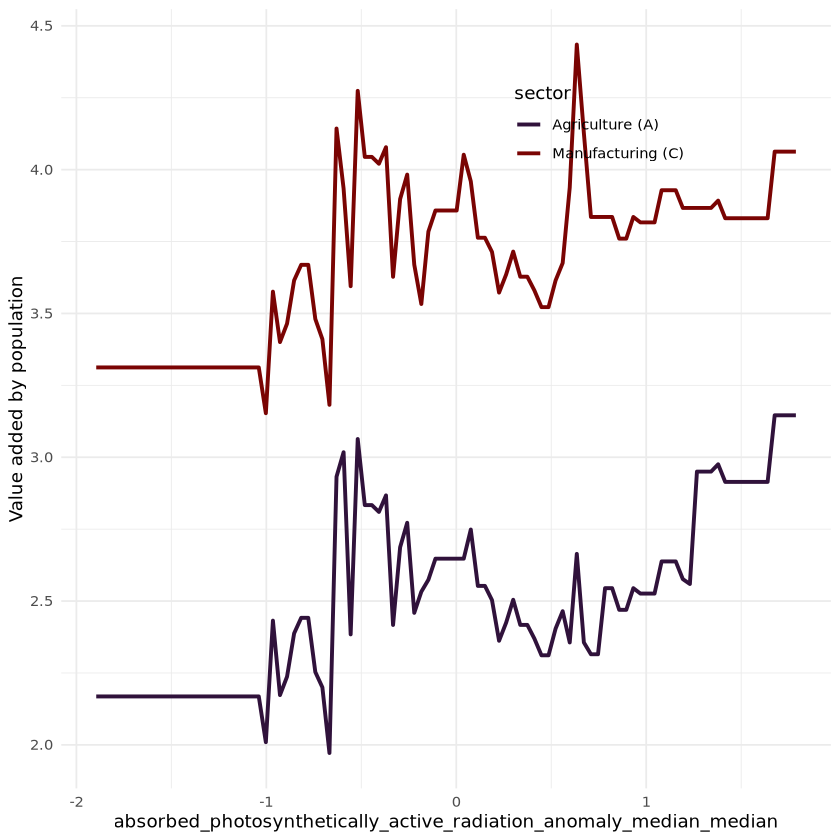

In [166]:
pdp = head(dat_imp3, 100)


pdp$temp_max_median_median = median(dat_imp3$temp_max_median_median)
pdp$low_flow_index_monthly_max_max = median(dat_imp3$low_flow_index_monthly_max_max)
pdp$soil_mosture_anomaly_median_median = median(dat_imp3$soil_mosture_anomaly_median_median)
pdp$precipitation_index_median_01_median = median(dat_imp3$precipitation_index_median_01_median)
pdp$precipitation_index_median_06_median = median(dat_imp3$precipitation_index_median_06_median)
pdp$precipitation_index_median_12_median = median(dat_imp3$precipitation_index_median_12_median)
pdp$temp_max_median_median = median(dat_imp3$temp_max_median_median)
pdp$heat_intensity_median_median = median(dat_imp3$heat_intensity_median_median)
pdp$gdp_pop = median(dat_imp3$gdp_pop)
pdp$absorbed_photosynthetically_active_radiation_anomaly_median_median = seq(from = min(dat_imp3$absorbed_photosynthetically_active_radiation_anomaly_median_median),
                                       to = max(dat_imp3$absorbed_photosynthetically_active_radiation_anomaly_median_median),
                                       by = (max(dat_imp3$absorbed_photosynthetically_active_radiation_anomaly_median_median) - min(dat_imp3$absorbed_photosynthetically_active_radiation_anomaly_median_median))/99)


pdp$empl_pop = median(dat_imp3$empl_pop)
pdp$gdp_ch = median(dat_imp3$gdp_ch)
        
pdp$nace = NULL
#pdp$naceA = 1
pdp$naceC = 1
pdp$naceA = 0
pdp$naceBE = 0
pdp$naceF = 0
pdp$naceGI = 0
pdp$naceGJ = 0
pdp$naceJ = 0
pdp$naceK = 0
pdp$naceKN = 0
pdp$naceL = 0
pdp$naceMN = 0
pdp$naceOQ = 0
pdp$naceOU  = 0
pdp$naceRU = 0
pdp$naceTOT = 0

pdp$empl_pop = median(dat_imp3$empl_pop)
pdp$gdp_ch = median(dat_imp3$gdp_ch)


pdp$country = NULL
pdp$countryIE = 0
pdp$countryAT = 0
pdp$countryNL = 0
pdp$countryDE = 0
pdp$countryNO = 0
pdp$countryDK = 0
pdp$countryBE = 0
pdp$countryUK = 0
pdp$countryFR = 0
pdp$countryEL = 1
pdp$countrySE = 0
pdp$countryES = 0
pdp$countryPT = 0
pdp$countryTR = 0
pdp$countryHU = 0
pdp$countrySI = 0
pdp$countryFI = 0
pdp$countryRO = 0
pdp$countryMT = 0
pdp$countryCH = 0
pdp$countryAL = 0
pdp$countryPL = 0
pdp$countryBG = 0
pdp$countryRS = 0
pdp$countrySK = 0
pdp$countryBA = 0
pdp$countryIT = 0
pdp$countryCZ = 0
pdp$countryLT = 0
pdp$countryLU = 0
pdp$countryUK = 0
pdp$countryCY = 0
pdp$countryEE = 0
pdp$countryHR = 0
pdp$countryMK = 0
pdp$countryAD = 0
pdp$countryIS = 0
pdp$countryLI = 0
pdp$countryLV = 0
pdp$countryME = 0
 #attributes(pdp$nace) =   attributes(dat_imp3$nace)           

pdp2 = pdp
pdp2$naceC = 0

#attributes(pdp2$nace) =   attributes(dat_imp3$nace) 
pdp3 = rbind(pdp, pdp2)

X_pdp = sparse.model.matrix(va_pop~., data = pdp3)[,-1]

X_pdp = X_pdp[,match(colnames(X),as.character(colnames(X_pdp)))]

pdp3$va_pop_pred = predict(mdl, X_pdp)
pdp3$va_pop_pred_mon = predict(mdl2, X_pdp)

pdp3$sector = ifelse(pdp3$naceC == 1, 'Manufacturing (C)','Agriculture (A)')


p2=
ggplot() + geom_line(data = pdp3, aes(absorbed_photosynthetically_active_radiation_anomaly_median_median, va_pop_pred_mon, group = sector, color = sector), size = 1.1) +
theme_minimal() +
 scale_color_viridis_d(option = "turbo")+ylab("Value added by population")+ theme(legend.position = c(.7,.85))

p2

#ggsave(p2, width = 12, height = 6,  filename = "temp_sector_pdp_2.pdf")

In [142]:
#Predictions / validation for 2019, 2020 and 2021



dat_val = dat_imputed |> ungroup() |> mutate(va_pop = value_added_mln_eur/population,
                                                     empl_pop = employment_000s / population,
                                                     gdp_ch = gdp /gdp_lag,
                                                     gdp_pop = gdp / population) |> filter(population != 0) |>
            #select(-value_added_mln_eur, -population, -employment_000s, -gdp, -gdp_lag) |>
            filter(!is.na(gdp_ch) & !is.na(empl_pop)) |> filter(year >= 2019 & year <= 2021) 

dat_val2 = dat_val |> select(-year, -value_added_mln_eur, -population, -employment_000s, -gdp, -gdp_lag) |>
                        mutate(nace = case_when(is.na(nace) ~ NA,
                                               nace == 'Agriculture, forestry and fishing [A]' ~ 'A',
                                               nace == 'Arts, entertainment and recreation; other service activities; activities of household and extra-territorial organizations and bodies [R-U]' ~ 'RU',
                                               nace == 'Construction [F]' ~ 'F',
                                               nace == 'Financial and insurance activities [K]' ~ 'K',
                                               nace == 'Financial and insurance activities; real estate activities; professional, scientific and technical activities; administrative and support service activities [K-N]' ~ 'KN',
                                               nace == 'Industry (except construction) [B-E]' ~ 'BE',
                                               nace == 'Information and communication [J]' ~ 'J',
                                               nace == 'Manufacturing [C]' ~ 'C',
                                               nace == 'Professional, scientific and technical activities; administrative and support service activities [M_N]' ~ 'MN',
                                               nace == 'Public administration and defence; compulsory social security; education; human health and social work activities; arts, entertainment and recreation, repair of household goods and other services [O-U]' ~ 'OU',
                                               nace == 'Public administration, defence, education, human health and social work activities [O-Q]' ~ 'OQ',
                                               nace == 'Real estate activities [L]' ~ 'L',
                                               nace == 'Total - all NACE activities [TOTAL]' ~ 'TOT',
                                               nace == 'Wholesale and retail trade, transport, accommodation and food service activities [G-I]' ~ 'GI',
                                               nace == 'Wholesale and retail trade; transport; accommodation and food service activities; information and communication [G-J]' ~ 'GJ',
                                               TRUE ~ nace))

dat_val2$country = substr(dat_val2$NUTS_ID,1,2)
dat_val2$nace = as.factor(dat_val2$nace)
dat_val2$country = as.factor(dat_val2$country)

dat_val3 = dat_val2 |> select(-NUTS_ID) #|> filter(nace %in% c('A','C'))


# model matrix


X_val = sparse.model.matrix(va_pop~., data = dat_val3)[,-1]
y_val <- as.numeric(as.character(dat_imp3 |> pull((va_pop))))





In [143]:
dat_val2$va_pop_pred = predict(mdl2, X_val)

dat_val2$population = dat_val$population 

dat_val2$value_added_predicted = dat_val2$va_pop_pred * dat_val2$population

dat_val2$year = dat_val$year
dat_val2 = dat_val2 |> rename(geo = NUTS_ID)

#gva_Agr and gva_Man 
results_long = dat_val2 |> select(geo, year, value_added_predicted, nace) |> filter(nace %in% c('A','C'))
results_wide = results_long |> pivot_wider(id_cols = c(geo, year), names_from = nace, values_from = value_added_predicted) |> rename(gva_Agr = 3, gva_Man = 4) |> filter(year < 2022)





In [160]:
results_wide_imp = 
results_wide |> mutate(country = substr(geo,1,2)) |> 
            group_by(year) |> mutate(gva_Agr_group = median(gva_Agr, na.rm = T),
                                              gva_Man_group = median(gva_Man, na.rm = T))

results_wide_imp$gva_Agr = ifelse(is.na(results_wide_imp$gva_Agr), results_wide_imp$gva_Agr_group, results_wide_imp$gva_Agr)
results_wide_imp$gva_Man = ifelse(is.na(results_wide_imp$gva_Man), results_wide_imp$gva_Man_group, results_wide_imp$gva_Man)

results_wide_imp = results_wide_imp |> select(-country, -gva_Agr_group,-gva_Man_group)
write.csv2(results_wide_imp, "Test_3.csv")